# Aiida

https://github.com/BAMresearch/NFDI4IngScientificWorkflowRequirements

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json

from aiida_workgraph import WorkGraph, task
from aiida import orm, load_profile
load_profile()

Profile<uuid='3b96612f59bb474b9a4c16a7676ab9bc' name='pwd'>

In [2]:
from nfdi_ing_workflow import (
    generate_mesh,
    convert_to_xdmf as _convert_to_xdmf,
    poisson as _poisson,
    plot_over_line,
    substitute_macros,
    compile_paper,
)

In [3]:
convert_to_xdmf = task(outputs=["xdmf_file", "h5_file"])(_convert_to_xdmf)
poisson = task(outputs=["numdofs", "pvd_file", "vtu_file"])(_poisson)

In [4]:
domain_size = orm.Float(2.0)

In [5]:
wg = WorkGraph("wg-nfdi")

In [6]:
gmsh_output_file = wg.add_task(
    generate_mesh,
    name="generate_mesh",
    domain_size=domain_size,
)

In [7]:
meshio_output_dict = wg.add_task(
    convert_to_xdmf,
    name="convert_to_xdmf",
    gmsh_output_file=gmsh_output_file.outputs.result,
)

In [8]:
poisson_dict = wg.add_task(
    poisson,
    name="poisson",
    meshio_output_xdmf=meshio_output_dict.outputs.xdmf_file, 
    meshio_output_h5=meshio_output_dict.outputs.h5_file,
)

In [9]:
pvbatch_output_file = wg.add_task(
    plot_over_line,
    name="plot_over_line",
    poisson_output_pvd_file=poisson_dict.outputs.pvd_file, 
    poisson_output_vtu_file=poisson_dict.outputs.vtu_file,
)

In [10]:
macros_tex_file = wg.add_task(
    substitute_macros,
    name="substitute_macros",
    pvbatch_output_file=pvbatch_output_file.outputs.result, 
    ndofs=poisson_dict.outputs.numdofs, 
    domain_size=domain_size,
)

In [11]:
paper_output = wg.add_task(
    compile_paper,
    name="compile_paper",
    macros_tex=macros_tex_file.outputs.result, 
    plot_file=pvbatch_output_file.outputs.result,
)

In [12]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-nfdi…

In [13]:
workflow_json_filename = "aiida_nfdi.json"

In [14]:
write_workflow_json(wg=wg, file_name=workflow_json_filename)

{'nodes': {'0': 'nfdi_ing_workflow.generate_mesh',
  '1': 'nfdi_ing_workflow.convert_to_xdmf',
  '2': 'nfdi_ing_workflow.poisson',
  '3': 'nfdi_ing_workflow.plot_over_line',
  '4': 'nfdi_ing_workflow.substitute_macros',
  '5': 'nfdi_ing_workflow.compile_paper',
  '6': 2.0},
 'edges': [{'tn': 1, 'th': 'gmsh_output_file', 'sn': 0, 'sh': None},
  {'tn': 2, 'th': 'meshio_output_xdmf', 'sn': 1, 'sh': 'xdmf_file'},
  {'tn': 2, 'th': 'meshio_output_h5', 'sn': 1, 'sh': 'h5_file'},
  {'tn': 3, 'th': 'poisson_output_pvd_file', 'sn': 2, 'sh': 'pvd_file'},
  {'tn': 3, 'th': 'poisson_output_vtu_file', 'sn': 2, 'sh': 'vtu_file'},
  {'tn': 4, 'th': 'pvbatch_output_file', 'sn': 3, 'sh': None},
  {'tn': 4, 'th': 'ndofs', 'sn': 2, 'sh': 'numdofs'},
  {'tn': 5, 'th': 'macros_tex', 'sn': 4, 'sh': None},
  {'tn': 5, 'th': 'plot_file', 'sn': 3, 'sh': None},
  {'tn': 0, 'th': 'domain_size', 'sn': 6, 'sh': None},
  {'tn': 4, 'th': 'domain_size', 'sn': 6, 'sh': None}]}

In [15]:
!cat {workflow_json_filename}

{
  "nodes": {
    "0": "nfdi_ing_workflow.generate_mesh",
    "1": "nfdi_ing_workflow.convert_to_xdmf",
    "2": "nfdi_ing_workflow.poisson",
    "3": "nfdi_ing_workflow.plot_over_line",
    "4": "nfdi_ing_workflow.substitute_macros",
    "5": "nfdi_ing_workflow.compile_paper",
    "6": 2.0
  },
  "edges": [
    {
      "tn": 1,
      "th": "gmsh_output_file",
      "sn": 0,
      "sh": null
    },
    {
      "tn": 2,
      "th": "meshio_output_xdmf",
      "sn": 1,
      "sh": "xdmf_file"
    },
    {
      "tn": 2,
      "th": "meshio_output_h5",
      "sn": 1,
      "sh": "h5_file"
    },
    {
      "tn": 3,
      "th": "poisson_output_pvd_file",
      "sn": 2,
      "sh": "pvd_file"
    },
    {
      "tn": 3,
      "th": "poisson_output_vtu_file",
      "sn": 2,
      "sh": "vtu_file"
    },
    {
      "tn": 4,
      "th": "pvbatch_output_file",
      "sn": 3,
      "sh": null
    },
    {
      "tn": 4,
      "th": "ndofs",
      "sn": 2,
      "sh": "numdofs"
    },
    {
  

## Load Workflow with jobflow

In [16]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [17]:
from jobflow.managers.local import run_locally

In [18]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [19]:
result = run_locally(flow)
result

2025-04-04 14:43:43,907 INFO Started executing jobs locally
2025-04-04 14:43:44,345 INFO Starting job - generate_mesh (d2959a22-7c6f-491e-8fa3-5e0b7bf851dd)
2025-04-04 14:43:46,611 INFO Finished job - generate_mesh (d2959a22-7c6f-491e-8fa3-5e0b7bf851dd)
2025-04-04 14:43:46,612 INFO Starting job - convert_to_xdmf (b6098203-f960-4c0f-a5f9-71fbbbfe226f)
2025-04-04 14:43:48,420 INFO Finished job - convert_to_xdmf (b6098203-f960-4c0f-a5f9-71fbbbfe226f)
2025-04-04 14:43:48,421 INFO Starting job - poisson (2daa1735-a65c-4b5b-aaf9-1141887b6fd6)
2025-04-04 14:44:00,271 INFO Finished job - poisson (2daa1735-a65c-4b5b-aaf9-1141887b6fd6)
2025-04-04 14:44:00,272 INFO Starting job - plot_over_line (b2126306-07e8-4f14-93ce-f7be95ee8f55)
2025-04-04 14:44:02,997 INFO Finished job - plot_over_line (b2126306-07e8-4f14-93ce-f7be95ee8f55)
2025-04-04 14:44:02,998 INFO Starting job - substitute_macros (09633e03-dcc8-4274-aa83-8151cd35878c)
2025-04-04 14:44:04,212 INFO Finished job - substitute_macros (09633e

{'d2959a22-7c6f-491e-8fa3-5e0b7bf851dd': {1: Response(output='/home/jovyan/preprocessing/square.msh', detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 'b6098203-f960-4c0f-a5f9-71fbbbfe226f': {1: Response(output={'xdmf_file': '/home/jovyan/preprocessing/square.xdmf', 'h5_file': '/home/jovyan/preprocessing/square.h5'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 '2daa1735-a65c-4b5b-aaf9-1141887b6fd6': {1: Response(output={'numdofs': 357, 'pvd_file': '/home/jovyan/processing/poisson.pvd', 'vtu_file': '/home/jovyan/processing/poisson000000.vtu'}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/jovyan'))},
 'b2126306-07e8-4f14-93ce-f7be95ee8f55': {1: Response(output='/home/jovyan/postprocessing/plotoverline.csv', detour=None, additi

## Load Workflow with pyiron_base

In [20]:
from pyiron_base import Project

In [21]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [22]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

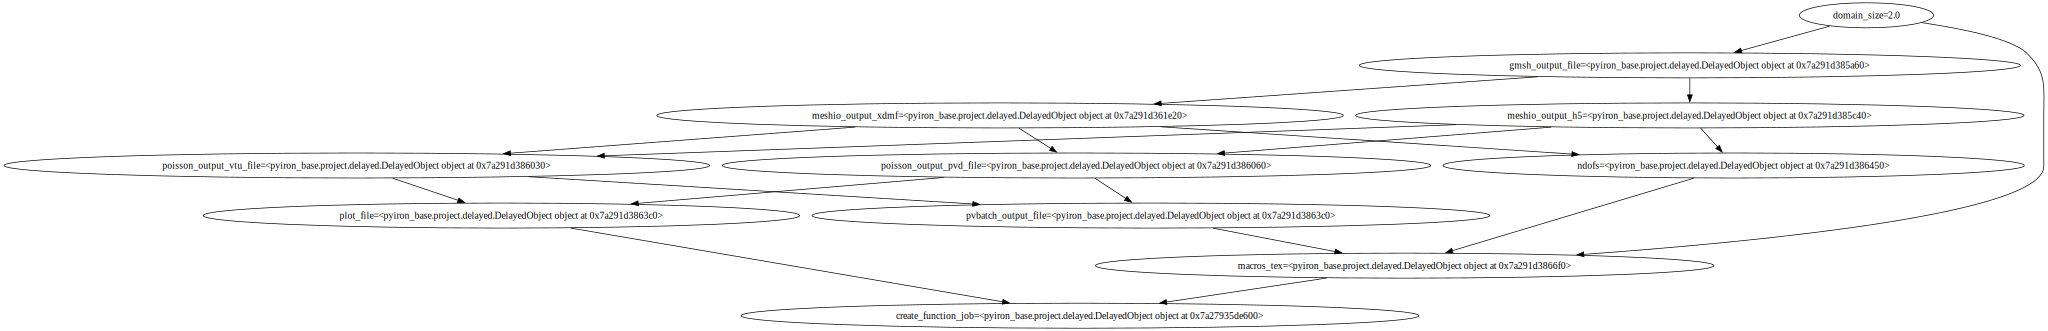

In [23]:
delayed_object = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object.draw()

In [24]:
delayed_object.pull()

The job generate_mesh_0b48cf5155cd6802c17d20bb58104132 was saved and received the ID: 1
The job convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43 was saved and received the ID: 2
The job poisson_a0224b23ceb2119d105a5d98ef37f93e was saved and received the ID: 3
The job plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b was saved and received the ID: 4
The job substitute_macros_874fc185ecec04b4cb9537c58b7efb7b was saved and received the ID: 5
The job compile_paper_3cee534ffe692833d37faf1fd2170cb6 was saved and received the ID: 6


'/home/jovyan/postprocessing/paper.pdf'

In [25]:
pr.job_table()

,id,status,chemicalformula,job,subjob,projectpath,project,timestart,timestop,totalcputime,computer,hamilton,hamversion,parentid,masterid
0,1,finished,None,generate_mesh_0b48cf5155cd6802c17d20bb58104132,/generate_mesh_0b48cf5155cd6802c17d20bb58104132,None,/home/jovyan/test/,2025-04-04 14:45:04.379468,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
1,2,finished,None,convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43,/convert_to_xdmf_29ad6ec6927268429dc9aef8166fde43,None,/home/jovyan/test/,2025-04-04 14:45:06.117232,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
2,3,finished,None,poisson_a0224b23ceb2119d105a5d98ef37f93e,/poisson_a0224b23ceb2119d105a5d98ef37f93e,None,/home/jovyan/test/,2025-04-04 14:45:08.009236,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
3,4,finished,None,plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b,/plot_over_line_82b37a42e0747f11d9a7f6318f63ac6b,None,/home/jovyan/test/,2025-04-04 14:45:11.395481,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
4,5,finished,None,substitute_macros_874fc185ecec04b4cb9537c58b7efb7b,/substitute_macros_874fc185ecec04b4cb9537c58b7efb7b,None,/home/jovyan/test/,2025-04-04 14:45:13.545508,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
5,6,finished,None,compile_paper_3cee534ffe692833d37faf1fd2170cb6,/compile_paper_3cee534ffe692833d37faf1fd2170cb6,None,/home/jovyan/test/,2025-04-04 14:45:14.745805,None,None,pyiron@jupyter-pyiron-dev-pyth-flow-definition-1xkr44oj#1,PythonFunctionContainerJob,0.4,None,None
